## HW 1

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
torch.manual_seed(0)

In [3]:
sentence = ["if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea."]
dtype = torch.float

### Word Processing

In [4]:
word_list = list(set("".join(sentence).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)

### TextRNN Parameter

In [5]:
batch_size = len(sentence)
n_step = 2
n_hidden = 5

In [6]:
def make_batch(sentence):
    input_batch = []
    target_batch = []
    
    for sen in sentence:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]
        
        input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
        target_batch.append(target)
    
    return input_batch, target_batch

input_batch, target_batch = make_batch(sentence)
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

### TextLSTM

In [7]:
class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=n_class,
                            hidden_size=n_hidden, dropout=0.3)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)
        
    def forward(self, hidden_and_cell, X):
        X = X.transpose(0, 1)
        outputs, hidden = self.lstm(X, hidden_and_cell)
        outputs = outputs[-1]  # 최종 예측 Hidden Layer
        model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
        return model

### Training

In [8]:
model = TextLSTM()

C:\Users\user\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [9]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),  lr=0.01)

In [11]:
# Training
for epoch in range(500):
    hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    output = model((hidden, cell), input_batch)
    loss = criterion(output, target_batch)
    
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

input = [sen.split()[:2] for sen in sentence]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model((hidden, cell), input_batch).data.max(1, keepdim=True)[1]
n = predict.squeeze()
print([sen.split()[:2] for sen in sentence], '->', [number_dict[n.item()]])

Epoch: 0100 cost = 0.001528
Epoch: 0200 cost = 0.001208
Epoch: 0300 cost = 0.000983
Epoch: 0400 cost = 0.000817
Epoch: 0500 cost = 0.000691
[['if', 'you']] -> ['sea.']


## HW 2

In [12]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [13]:
def findFiles(path): return glob.glob(path)
print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [14]:
import unicodedata
import string

all_letters = string.ascii_letters + ".,;''"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [15]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [16]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [17]:
import torch

# all_letters로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한개의 문자를 < 1 x n_letters > Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)]=1
    return tensor

# 한 줄(이름)을 <line_length x 1 x n_letters>,
# 또는 Ohe-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)]=1
        return tensor
    
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [18]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [19]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [20]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9290, -2.8576, -3.0069, -2.8838, -2.8834, -2.8175, -2.8922, -2.9037,
         -2.9706, -2.9701, -2.8044, -2.9416, -2.8719, -2.8569, -2.8628, -2.8748,
         -2.8718, -2.8519]], grad_fn=<LogSoftmaxBackward>)


In [21]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 10)


In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/line =',line)

category = Chinese /line = Mao
category = Japanese /line = Yasuda
category = Spanish /line = Arce
category = Italian /line = Altimari
category = Vietnamese /line = Ngo
category = Dutch /line = Schneijder
category = Italian /line = Robustelli
category = Korean /line = Ngai
category = Irish /line = Muirchertach
category = Italian /line = Benetton


In [23]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 2.4862 Kotsilimbas / Greek ✓
10000 10% (0m 29s) 2.5071 Lopez / Arabic ✗ (Spanish)
15000 15% (0m 44s) 1.3300 Morzhitsky / Greek ✗ (Russian)
20000 20% (0m 58s) 2.7175 Pinheiro / Japanese ✗ (Portuguese)
25000 25% (1m 13s) 2.5513 Monette / Portuguese ✗ (French)
30000 30% (1m 27s) 2.5374 Schlantz / Greek ✗ (Czech)
35000 35% (1m 42s) 2.4920 Ardizzone / Greek ✗ (Italian)
40000 40% (1m 57s) 2.7682 Duguay / Arabic ✗ (French)
45000 45% (2m 15s) 0.9123 Do / Vietnamese ✓
50000 50% (2m 35s) 2.9622 Krantz / Arabic ✗ (Dutch)
55000 55% (3m 0s) 4.6434 Cruz / Korean ✗ (Portuguese)
60000 60% (3m 22s) 1.2849 Yamlikhanov / Polish ✗ (Russian)
65000 65% (3m 41s) 0.7973 Wen / Chinese ✓
70000 70% (4m 0s) 2.8878 Paulis / French ✗ (Dutch)
75000 75% (4m 16s) 1.9641 Moreno / Portuguese ✓
80000 80% (4m 34s) 3.2109 Russell / Portuguese ✗ (Scottish)
85000 85% (4m 52s) 2.9298 Mojjis / Portuguese ✗ (Czech)
90000 90% (5m 7s) 0.7156 an / Vietnamese ✓
95000 95% (5m 21s) 1.9260 Amador / Spanish ✓
100000 10

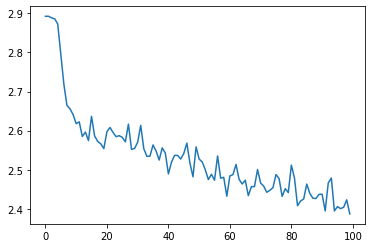

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

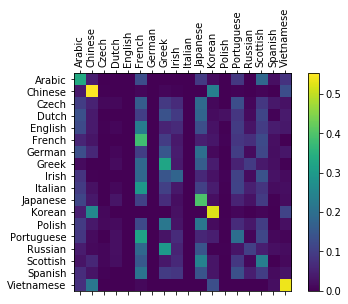

In [26]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 중에 어떤 것이 정확하게 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guress, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [27]:
def predict(input_line, n_predictions=3):
    print('\n< %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topi[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


< Dovesky
(5.00) French
(13.00) Portuguese
(8.00) Irish

< Jackson
(8.00) Irish
(3.00) Dutch
(13.00) Portuguese

< Satoshi
(13.00) Portuguese
(3.00) Dutch
(5.00) French
